# The missing Irish Pub
## IBM Data Science Professional Certificate Capstone Project   
  
  

Christian Weymann, chrisitan.weymann@bluewin.ch

We want to open a new Irish Pub in New York City. For this enterprise to be a success, we have to find a good location. We will use Foursquare data to determine in what type of neighborhood (identified by the typical venues in this neighborhood) Irish Pubs are currently established, to try and find a similar neighborhood with no Irish Pub. We identify several of such opportunities, the most promising one being the Tribeca neighborhood in Manhattan according to our model.

## 1. Introduction
In a large city like New York, each neighborhood can have a different feel to it: some are purely residential, others have a lot of shopping opportunities, or business centers, or nightlife venues. Implanting a new business in the wrong type of neighborhood can be a fast road to failure, as customers will not think of going to that location for this type of service. It also drastically reduces the chances of being discovered by accident by a customer who was already in the area.

In this project, we will take the example of Irish pubs to demonstrate this principle. Using data from the Foursquare Places API, we will determine what kind of neighborhood would be a good location for a new Irish pub in New York City. To this end, we will try to predict the number of Irish pubs in each neighborhood based on the frequency of other types of venues present in that area. We can then compare the predicted number to the actual number to identify opportunities.

The same kind of analysis done here for Irish pubs could be done for any type of business. Any prospective business owner could benefit from reproducing it. It could also be used by local governments to try to get a more data backed understanding of the area under their responsibility, and what kind of businesses they need to attract if they want to change the feel of their neighborhood.


## 2. Data
Our data will mostly be loaded from the Foursquare Places API. Foursquare maintains a list of venues with a lot of rich data associated with each of them, such as ratings and comments from its users. However, we will be mostly focused on core data about each venue: its geographical position, and its category. Foursquare lists the category of each venue both with a name and a unique category identifier which can be used in searches. We will take advantage of this to find all the Irish Pubs in each neighborhood. The geographical data of each neighborhood will be taken from the json file used during the lab session of this course.

In the cell below, we load all the necessary libraries to load the data from Foursquare, to explore it in Python, and to generate graphs and maps from it.

In [1]:
#standard libraries to handle our data
import pandas as pd
import numpy as np

#libraries to handle json files and the interactions with the REST API
import json
import requests

#geocoding library
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

#library to handle maps
import folium

#plotting library
import matplotlib.pyplot as plt

We will use a geolocator to get the latitude and longitude of New York City to initialise our maps.

In [2]:
#initialise the geolocator and the rate limiter
geolocator = Nominatim(user_agent='irish_explorer')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1, max_retries=2)

In [3]:
#central location for our maps
location = geocode('New York City, NY')
latitude = location.latitude
longitude = location.longitude

In this next code cell, we load all the parameters needed to access the API, as well as the identifier for Irish Pubs. All the data needed to run this notebook will also be saved locally in case you don't have Foursquare credentials.

In [4]:
#'Foursquare_identifier' is a text file with the client ID on the first line and the client secret on the second line
with open('Foursquare_identifier') as ID: 
    #Read the identifiers, removing the endline character
    CLIENT_ID = ID.readline()[:-1]
    CLIENT_SECRET = ID.readline()[:-1]
VERSION = '20201027'
LIMIT = 100

IRISH_PUBS = '52e81612bcbc57f1066b7a06' #the category identifier for Irish Pubs

We will now recreate the `neighborhoods` data frame from the lab session.

In [5]:
#load data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

neighborhoods_data = newyork_data['features']

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
#fill the dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

All the neighborhoods have been loaded in the dataframe. For further analysis, we need a unique identifier for each neighborhood. Let's check if the name of the neighborhood is appropriate:

In [9]:
neighborhoods[neighborhoods['Neighborhood'].duplicated(keep=False)]

Borough Neighborhood   Latitude  Longitude
115      Manhattan  Murray Hill  40.748303 -73.978332
116      Manhattan      Chelsea  40.744035 -74.003116
140         Queens    Sunnyside  40.740176 -73.926916
175         Queens  Bay Terrace  40.782843 -73.776802
180         Queens  Murray Hill  40.764126 -73.812763
220  Staten Island    Sunnyside  40.612760 -74.097126
235  Staten Island  Bay Terrace  40.553988 -74.139166
244  Staten Island      Chelsea  40.594726 -74.189560

Several neighborhoods accross different boroughs share a name, therefore we cannot use it as a unique identifier. Instead, we will use the index of the `neighborhoods` dataframe as an identifier for each neighborhood.

Let us now load the data we are interested in from Foursquare. We will first creat a dataframe of all the Irish Pubs in New York City. To this end, we will use the `/venues/search` endpoint of the Places API, which allows id to pass a `categoryId` parameter to limit our search only to Irish Pubs.

To avoid issues with failing connections, we will pass a target list to our function to get venues, so that the results of atemps done before the one that failed are still saved. We can then rerun the main loop on a slice of the original dataframe to add the remaining entries, and convert to a data frame once we are done.

In [10]:
#function to get the irish pubs in every area defined in source_df
def getPubs(source_df, target_list, radius=500):
    for ID, _, _, lat, lng in source_df.itertuples():
        # create the API request URL
        url = ('https://api.foursquare.com/v2/venues/search?'
               '&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}').format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius,
            LIMIT,
            IRISH_PUBS,
            )
        
        #try the get request
        try:
            results = requests.get(url).json()['response']['venues']
        except:
            print(f'Failed at index {ID}')
            raise
        
        #extend the target dataframe
        target_list.extend({'Neighborhood ID': ID, 
                  'Neighborhood Latitude': lat, 
                  'Neighborhood Longitude': lng, 
                  'Pub Name': v['name'], 
                  'Pub Latitude': v['location']['lat'], 
                  'Pub Longitude': v['location']['lng']}
                         for v in results)

In [11]:
#Initialise target list
pub_list = []

In [12]:
#This cell can be run multiple times by changing the slice to start at the failed ID
getPubs(neighborhoods.loc[:], pub_list)

In [13]:
#convert finished list
neighborhood_pubs = pd.DataFrame(pub_list)

Neighborhood ID  Neighborhood Latitude  Neighborhood Longitude  \
0                7              40.898273              -73.867315   
1               46              40.625801              -74.030621   
2               62              40.698116              -73.925258   
3               99              40.614768              -74.031979   
4              102              40.867684              -73.921210   

                Pub Name  Pub Latitude  Pub Longitude  
0         Aqueduct North     40.897812     -73.867533  
1           O'Sullivan's     40.621353     -74.031903  
2  Bushwick Public House     40.698105     -73.924871  
3         Pipin's Pop Up     40.620279     -74.032230  
4      Tubby Hook Tavern     40.867739     -73.920628

In [10]:
#Save/load dataframe to not have to request it from Foursquare every time
#neighborhood_pubs.to_csv('neighborhood_pubs.csv')
neighborhood_pubs = pd.read_csv('neighborhood_pubs.csv', index_col=0)
neighborhood_pubs.head()

Neighborhood ID  Neighborhood Latitude  Neighborhood Longitude  \
0                7              40.898273              -73.867315   
1               46              40.625801              -74.030621   
2               62              40.698116              -73.925258   
3               99              40.614768              -74.031979   
4              102              40.867684              -73.921210   

                Pub Name  Pub Latitude  Pub Longitude  
0         Aqueduct North     40.897812     -73.867533  
1           O'Sullivan's     40.621353     -74.031903  
2  Bushwick Public House     40.698105     -73.924871  
3         Pipin's Pop Up     40.620279     -74.032230  
4      Tubby Hook Tavern     40.867739     -73.920628

Our dataframe of Irish Pubs has been succesfully created. Let us explore it for a bit! First, show their position on a map:

In [11]:
#Create the map
map_pubs = folium.Map(location=[latitude, longitude], zoom_start=11)

#Helper function that we can apply to our dataframe to draw markers for each pub
def add_marker(row, target_map):
    label = '{}'.format(row['Pub Name'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row['Pub Latitude'], row['Pub Longitude']],
        popup=label,
        radius=5,
        fill=True,
        fill_opacity=0.7,
    ).add_to(target_map)
    
neighborhood_pubs.apply(add_marker, axis=1, args=(map_pubs,))

map_pubs

Next, let us see what words are commonly used in an Irish Pub's name:

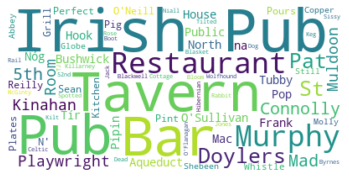

In [12]:
#Let's make a wordcloud from the pub names to find the perfect name
from wordcloud import WordCloud

pub_names_wc = WordCloud(
    background_color='white',
).generate(neighborhood_pubs['Pub Name'].str.cat(sep=' '))

# display the word cloud
plt.imshow(pub_names_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

We will create a `neighborhoods_results` dataframe to keep track of our intermediate results, linking them back to the neighborhood information, without risking to accidentally modify our reference `neighborhoods` dataframe. Here, we add a column counting the number of Irish Pubs in each neighborhood, which will be our target variable in the end.

In [13]:
neighborhoods_results = (neighborhoods.join(neighborhood_pubs
                                               .groupby('Neighborhood ID')
                                               .count()['Pub Name']
                                               .rename('Pub Count'))
                                      .fillna(0))

Let's explore this target variable:

<AxesSubplot:ylabel='Frequency'>

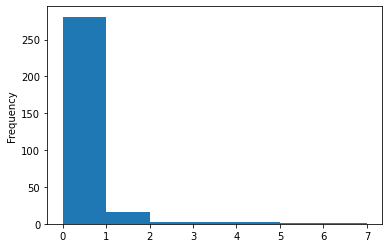

In [14]:
#plot the distribution of the number of pubs in each neighborhood
neighborhoods_results['Pub Count'].plot.hist(bins=7)

In [15]:
neighborhoods_results.value_counts(['Pub Count'], sort=False)

Pub Count
0.0          281
1.0           16
2.0            2
3.0            2
4.0            3
5.0            1
7.0            1
dtype: int64

We can see that the distribution of pub counts is heavily skewed towards low numbers: 281 neighborhoods have no Irish Pub at all. This is expected for a variable discribing the number of occurrences of a rare event, which is best described using a Poisson distribution.

We will now try and identify the typical venues present in each neighborhood. This should give us an idea of the type of neighborhood we are dealing with, and be used to predict the number of Irish Pubs in each neighborhood. For this, we will use the `/venues/explore` endpoint in the Places API, which, among other things, allows us to not pass a `radius` parameter and will select a search radius depending on the venue density in each neighborhood.

Same strategy as getting local pubs to get local venues.

In [29]:
#function to get typical venues in every area defined in source_df
def getTypical(source_df, target_list):
    for ID, _, _, lat, lng in source_df.itertuples():
        # create the API request URL
        url = ('https://api.foursquare.com/v2/venues/explore?'
               '&client_id={}&client_secret={}&v={}&ll={},{}&limit={}').format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            LIMIT)
        
        #try the get request
        try:
            response = requests.get(url).json()
            results = response['response']['groups'][0]['items']
        except (KeyError, TypeError):
            #the response does not have the expected format
            print(f'Failed at index {ID}')
            print(response)
            raise
        except:
            #something else went wrong
            print(f'Failed at index {ID}')
            raise
        
        #extend the target dataframe
        target_list.extend({'Neighborhood ID': ID, 
                  'Neighborhood Latitude': lat, 
                  'Neighborhood Longitude': lng, 
                  'Venue': v['venue']['name'], 
                  'Venue Latitude': v['venue']['location']['lat'], 
                  'Venue Longitude': v['venue']['location']['lng'], 
                  'Venue Category': v['venue']['categories'][0]['name']}
                         for v in results)

In [30]:
#Initialise target list
venue_list = []

In [33]:
#This cell can be run multiple times by changing the slice to start at the failed ID
getTypical(neighborhoods.loc[105:], venue_list)

In [35]:
#convert finished list
typical_venues = pd.DataFrame(venue_list)

Neighborhood ID  Neighborhood Latitude  Neighborhood Longitude  \
0                0              40.894705              -73.847201   
1                0              40.894705              -73.847201   
2                0              40.894705              -73.847201   
3                0              40.894705              -73.847201   
4                0              40.894705              -73.847201   

                         Venue  Venue Latitude  Venue Longitude  \
0             Lollipops Gelato       40.894123       -73.845892   
1           Ripe Kitchen & Bar       40.898152       -73.838875   
2              Ali's Roti Shop       40.894036       -73.856935   
3  Jackie's West Indian Bakery       40.889283       -73.843310   
4     Kingston Tropical Bakery       40.888568       -73.859885   

         Venue Category  
0          Dessert Shop  
1  Caribbean Restaurant  
2  Caribbean Restaurant  
3  Caribbean Restaurant  
4                Bakery

In [18]:
#Save/load dataframe to not have to request it from Foursquare every time
#typical_venues.to_csv('typical_venues.csv')
typical_venues = pd.read_csv('typical_venues.csv', index_col=0)
typical_venues.head()

Neighborhood ID  Neighborhood Latitude  Neighborhood Longitude  \
0                0              40.894705              -73.847201   
1                0              40.894705              -73.847201   
2                0              40.894705              -73.847201   
3                0              40.894705              -73.847201   
4                0              40.894705              -73.847201   

                         Venue  Venue Latitude  Venue Longitude  \
0             Lollipops Gelato       40.894123       -73.845892   
1           Ripe Kitchen & Bar       40.898152       -73.838875   
2              Ali's Roti Shop       40.894036       -73.856935   
3  Jackie's West Indian Bakery       40.889283       -73.843310   
4     Kingston Tropical Bakery       40.888568       -73.859885   

         Venue Category  
0          Dessert Shop  
1  Caribbean Restaurant  
2  Caribbean Restaurant  
3  Caribbean Restaurant  
4                Bakery

We have our list of typical venues!

Let us check how many different categories we have:

In [19]:
typical_venues['Venue Category'].unique().shape

(446,)

This seems like a lot of different categories, which will lead to very sparse data. It might be usefull to group some venue categories together (all asian restaurants for example, or all outdoor sports venues). Fortunately, Foursquare does this for us, as all categories are sorted in a hierarchical structure, which we can access using the `/venues/categories` endpoint of the Places API.

In [20]:
#get the categories list from Foursquare
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID,
    CLIENT_SECRET, 
    VERSION,
)
results = requests.get(url).json()

Let's look at how the data is structured:

In [194]:
results

{'meta': {'code': 200, 'requestId': '5fbe4378432e02660c730cbe'},
 'response': {'categories': [{'id': '4d4b7104d754a06370d81259',
    'name': 'Arts & Entertainment',
    'pluralName': 'Arts & Entertainment',
    'shortName': 'Arts & Entertainment',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
     'suffix': '.png'},
    'categories': [{'id': '56aa371be4b08b9a8d5734db',
      'name': 'Amphitheater',
      'pluralName': 'Amphitheaters',
      'shortName': 'Amphitheater',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4fceea171983d5d06c3e9823',
      'name': 'Aquarium',
      'pluralName': 'Aquariums',
      'shortName': 'Aquarium',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
       'suffix': '.png'},
      'categories': []},
     {'id': '4bf58dd8d48988d1e1931735',
      'name': 'A

The hierarchy starts at `respose/categories`, which is a list of the top level categories. Each category has an attribute `name` which is what we have loaded into our other dataframes. Each category also has an attribute `categories` which is a list of all the subcategories of this particular category. If it does not have subcategories, the list is empty, but the attribute is still defined. Let's start by loading the list of primary categories in a variable:

In [21]:
cat_hierarchy = results['response']['categories']

Let's save this for offline use:

In [6]:
##Save cat_hierarchy to not have to request it every time
#with open('categories.json', 'w', encoding='utf-8') as f:
#    json.dump(cat_hierarchy, f, ensure_ascii=False, indent=4)

In [7]:
##Load the local hierarchy
#with open('categories.json') as json_data:
#    cat_hierarchy = json.load(json_data)

We will now define a function to recursively search through the category hierarchy and return the labels of the branch it is on:

In [22]:
#function to find a specific category in the category list of Foursquare
def find_parents(cat_name, cat_list):
    for cat in cat_list:
        #The category is found if its name matches the search term
        if cat['name'] == cat_name: 
            #In this case, we will initialise the label list
            return [cat_name]
        else:
            #cat['category'] is defined for every category, but empty if there are no subcategories
            child = find_parents(cat_name, cat['categories']) 
            if child is not None: #The category is found in the children
                return [cat['name']] + child #Add the category name to the branch label list
    
    return None #cat_list is empty, we've reached the end of a branch

Let's see an example:

In [23]:
find_parents('Ramen Restaurant', cat_hierarchy)

['Food', 'Asian Restaurant', 'Japanese Restaurant', 'Ramen Restaurant']

We see that 'Ramen Restaurant' is a subcategory of 'Japanese Restaurant', which is a subcategory of 'Asian Restaurant', which is a subcategory of 'Food'. We can now find the parent categories of each of our typical venues:

In [24]:
venue_parents = {} #buffer dictionnary for the parents of each unique category
typical_venues['Venue Parents'] = typical_venues['Venue Category'].map(
    lambda cat: venue_parents[cat] 
    if cat in venue_parents #the category was already analysed, copy result
    else venue_parents.setdefault(cat, find_parents(cat, cat_hierarchy)) #the category was never analysed, 
)                                                                        #find in the hierarchy and save results
#Note to self: this could also be achieved by memoising 'find_parents'

<AxesSubplot:ylabel='Frequency'>

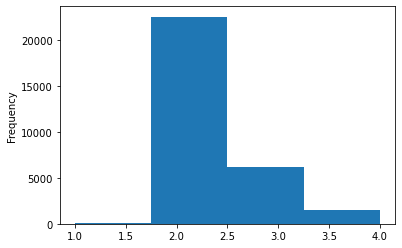

In [25]:
typical_venues['Venue Parents'].map(len).plot.hist(bins=4)

We can see that most of our venues' categories have one parent category (in addition of their own sub-category). This is the case, for example, with most restaurants, where the `Venue Parents` column will look somethin like `[Food, xxx Restaurant]`.

Let's unpack the list we crated into different columns for ease of access.

In [26]:
#lets unpack the 'Venue Parents' list into several columns
typical_venues = typical_venues.join(pd.DataFrame(typical_venues['Venue Parents'].to_list(),
                                     index=typical_venues.index).add_prefix('Parent '))

In [27]:
typical_venues.head()

Neighborhood ID  Neighborhood Latitude  Neighborhood Longitude  \
0                0              40.894705              -73.847201   
1                0              40.894705              -73.847201   
2                0              40.894705              -73.847201   
3                0              40.894705              -73.847201   
4                0              40.894705              -73.847201   

                         Venue  Venue Latitude  Venue Longitude  \
0             Lollipops Gelato       40.894123       -73.845892   
1           Ripe Kitchen & Bar       40.898152       -73.838875   
2              Ali's Roti Shop       40.894036       -73.856935   
3  Jackie's West Indian Bakery       40.889283       -73.843310   
4     Kingston Tropical Bakery       40.888568       -73.859885   

         Venue Category                 Venue Parents Parent 0  \
0          Dessert Shop          [Food, Dessert Shop]     Food   
1  Caribbean Restaurant  [Food, Caribbean Restaurant]     Food   
2  Caribbean Restaurant  [Food, Caribbean Restaurant]     Food   
3  Caribbean Restaurant  [Food, Caribbean Restaurant]     Food   
4                Bakery                [Food, Bakery]     Food   

               Parent 1 Parent 2 Parent 3  
0          Dessert Shop     None     None  
1  Caribbean Restaurant     None     None  
2  Caribbean Restaurant     None     None  
3  Caribbean Restaurant     None     None  
4                Bakery     None     None

Finally, we need to transform the data in such a way that it can be used as input for our machine learning methods. We use one-hot encoding to change the categorical data in `Venue Category` to numerical, and then do a mean for each neighborhood, wich results in the frequency of each type of venue with respect to all the venues for each neighborhood.

In [28]:
#function to get the frequency of each type of venue in each neighborhood from a series of categories and neighborhoods
def get_frequencies(categories, hoodIDs):
    onehot = pd.get_dummies(categories)
    onehot.insert(0, 'Neighborhood ID', hoodIDs)
    freq = onehot.groupby('Neighborhood ID').mean()
    
    return freq.join(neighborhoods_results['Pub Count'])

In [29]:
#get the frequencies of the original categories
print(f'There are {typical_venues.shape[0]} venues in our dataset')
freq_child = get_frequencies(typical_venues['Venue Category'], 
                             typical_venues['Neighborhood ID'])
print(f'{freq_child.shape[0]} neighborhoods and {freq_child.shape[1]-1} categories are represented in our dataset')
freq_child.head()

There are 30234 venues in our dataset
306 neighborhoods and 446 categories are represented in our dataset


Accessories Store  Adult Boutique  Afghan Restaurant  \
Neighborhood ID                                                         
0                              0.0             0.0                0.0   
1                              0.0             0.0                0.0   
2                              0.0             0.0                0.0   
3                              0.0             0.0                0.0   
4                              0.0             0.0                0.0   

                 African Restaurant  Airport Food Court  Airport Lounge  \
Neighborhood ID                                                           
0                               0.0                 0.0             0.0   
1                               0.0                 0.0             0.0   
2                               0.0                 0.0             0.0   
3                               0.0                 0.0             0.0   
4                               0.0                 0.0             0.0   

                 Airport Service  American Restaurant  Animal Shelter  \
Neighborhood ID                                                         
0                            0.0                 0.02             0.0   
1                            0.0                 0.00             0.0   
2                            0.0                 0.00             0.0   
3                            0.0                 0.00             0.0   
4                            0.0                 0.00             0.0   

                 Antique Shop  ...  Whisky Bar  Wine Bar  Wine Shop  Winery  \
Neighborhood ID                ...                                            
0                         0.0  ...         0.0       0.0   0.000000     0.0   
1                         0.0  ...         0.0       0.0   0.010000     0.0   
2                         0.0  ...         0.0       0.0   0.010000     0.0   
3                         0.0  ...         0.0       0.0   0.020000     0.0   
4                         0.0  ...         0.0       0.0   0.011236     0.0   

                 Wings Joint  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  \
Neighborhood ID                                                              
0                   0.000000           0.00     0.000000  0.0          0.0   
1                   0.000000           0.00     0.000000  0.0          0.0   
2                   0.010000           0.01     0.000000  0.0          0.0   
3                   0.010000           0.00     0.010000  0.0          0.0   
4                   0.011236           0.00     0.011236  0.0          0.0   

                 Pub Count  
Neighborhood ID             
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  

[5 rows x 447 columns]

We have a total of 30234 venues in 306 neighborhoods with 446 different categories, to which one column was added for the pub count in the neighborhood. This is very sparse, and we will try to limit the number of different categories by going up in the category hierarchy.

In [30]:
#get the frequencies for increasingly detailed categories, droping the ones which do not have that level of detail
freq_depth = []
for i in range(4):
    depth = typical_venues[['Neighborhood ID', f'Parent {i}']].dropna()
    print(f'There are {depth.shape[0]} venues in our dataset with a category depth of at least {i}')
    freq_depth.append(get_frequencies(depth[f'Parent {i}'], depth['Neighborhood ID']))

There are 30234 venues in our dataset with a category depth of at least 0
There are 30188 venues in our dataset with a category depth of at least 1
There are 7667 venues in our dataset with a category depth of at least 2
There are 1452 venues in our dataset with a category depth of at least 3


As we've seen before, most of our venues' categories have at least one level of depth. However, if we look only at the venues with a category of depth at least 2, we see that we go from over 30000 venues to 7667, which seems like an unaceptable loss of information.

In [31]:
#check the number of categories for each depth
for i, freq in enumerate(freq_depth):
    print(f'{freq.shape[0]} neighborhoods and {freq.shape[1]-1} categories are represented in the dataset of depth {i}')

306 neighborhoods and 9 categories are represented in the dataset of depth 0
306 neighborhoods and 287 categories are represented in the dataset of depth 1
306 neighborhoods and 134 categories are represented in the dataset of depth 2
298 neighborhoods and 27 categories are represented in the dataset of depth 3


There are 9 main categories in the Foursquare category hierarchy, which are all represented in our dataset. We see that going one level down we are dealing with 287 different categories (down from 446), which should increase the density of our frequency table. For higher depth, we see that the number of categories actually goes down, which is due to the all of the data that is no longer considered. For the highest depth, we lose so much data that not even every neighborhood is represented. We will therefore limit our analysis to depth levels 0 and 1.

In [32]:
freq_depth = freq_depth[:2]

We can check what type of venues get grouped together in the dataset of depth 1:

In [60]:
for parent, children in typical_venues.groupby('Parent 1'):
    child_list = children['Venue Category'].unique()
    if len(child_list) > 1:
        child_str = ', '.join(child_list)
        print(parent+': '+child_str)

African Restaurant: African Restaurant, Ethiopian Restaurant
Airport: Airport Lounge, Airport Service, Airport Food Court
American Restaurant: American Restaurant, New American Restaurant
Asian Restaurant: Asian Restaurant, Chinese Restaurant, Japanese Restaurant, Sushi Restaurant, Thai Restaurant, Vietnamese Restaurant, Korean Restaurant, Noodle House, Cantonese Restaurant, Dim Sum Restaurant, Ramen Restaurant, Hotpot Restaurant, Szechuan Restaurant, Taiwanese Restaurant, Malay Restaurant, Tibetan Restaurant, Filipino Restaurant, Burmese Restaurant, Shanghai Restaurant, Japanese Curry Restaurant, Udon Restaurant, Hunan Restaurant, Himalayan Restaurant, Indonesian Restaurant, Soba Restaurant
Athletics & Sports: Gym / Fitness Center, Gym, Golf Driving Range, Golf Course, Martial Arts School, Track, Yoga Studio, Athletics & Sports, Tennis Court, Basketball Court, Soccer Field, Baseball Field, Gymnastics Gym, Sports Club, Skating Rink, Cycle Studio, Pilates Studio, Boxing Gym, Climbing Gy

We see that most restaurants get grouped by continent, sport centers get grouped together, food and drinks shops as well, and so on. Overall this grouping seems to make sense.

## 3. Methods
We want to train a model on the current data of neighborhoods in New York City to figure out where an Irish pub could be added, that is find a neighborhood similar to another one with more Irish Pubs. We see three main types of models which could achieve this goal:

1. A classification model trained to differentiate neighborhoods with at least one Irish Pub from neighborhoods with no Irish Pubs. We could then see which neighborhood with no Irish Pub would be classified as having one, indicating the model sees similarities with neighborhoods with an Irish Pub. This option would not allow us to find an opportunity in a neighborhood that already contains an Irish Pub. Furthermore, the training would be complicated by the extreme imbalance in the classes: out of 306 neighborhoods, only 25 have at least one Irish Pub.

2. A recommender system, by treating the Irish Pubs as a user, and the neighborhoods as products to be recommended to them. We can then just see what neighborhood the algorithm would recommend next. A starting point for a similarity metric between neighborhoods could be the cosine similarity between their frequency vectors, which is implemented in `scikit-learn`. This approach might be biased towards neighborhoods which already have several Irish Pubs.

3. A regressor model that fits the distribution of the number of Pubs in each neighborhood. As we've seen above, the distribution seems to follow a Poisson distribution, which can be fitted using the `PoissonRegressor` from `scikit-learn`. We can then look at the difference between the predicted and the actual number of Irish Pubs in each neighborhood to identify opportunities.

Due to the limited timeframe of this assignment, we decided to only implement option 3, as it seemed the most likely to succeed.

We start by loading the needed classes and functions that we did not load earlier. To get a baseline on our metrics, we will test a dummy regressor that always guesses the mean of the dataset. That should give it a relatively high hit rate, as our dataset is quite imbalanced.

In [34]:
#The two regressors we will test on our problem
from sklearn.linear_model import PoissonRegressor
from sklearn.dummy import DummyRegressor

#Helper function for parameter selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

Let's define a helper function to extract the features from our dataframes:

In [35]:
#Helper function to turn our dataframes into X and y arrays
def get_features(freq):
    X = freq.drop(['Pub Count'], axis='columns').to_numpy()
    y = freq['Pub Count'].to_numpy()
    return X, y

Here we initialise our regressors and the search grid for the regularisation parameter of the `PoissonRegressor`:

In [36]:
dummy = DummyRegressor(strategy='mean') #Always tries the mean of the dataset
poisson = PoissonRegressor(max_iter=1000) #Fits a poisson distribution
search_grid = {'alpha': np.logspace(-6, 6, 13)} #Regularisation parameter to optimise

Now let's try our different regressors for three datasets we constructed:
* `Child` is based on the original venue categories
* `Parent 0` is based on the first element of the hierarchical path to the venue category and
* `Parent 1` is based on the second element of the path

In each case, we will evalute a dummy regressor and the poisson regressor. They will be scored using the negative mean poisson deviance, an analogue to negative mean squared error suited for poisson regressions. By convention higher score is better, which in this case means lower absolute value (less negative) score is better. For the dummy regressor, since there are no parameters to optimise, we will consider the mean of the score of each of the folds of a five fold cross validation, where the regressor is trained on 80% of the data and then tested on the remaining 20%. For the poisson regressor, we want to optimise the regularisation parameter, which we can do automatically by cross validation using the wrapper class `GridSearchCV`. The constructor will search the parameter space we suplied by cross validation and return an instance of the poisson regressor fitted with the whole dataset and the optimised parameters. Therefore, and since information about the left out fold can leak into the parameter optimisation, we first have to split the data set into a train and test set to best evaluate the out-of-sample performance of the optimised regressor.

In [37]:
#Try predictions with the different datasets we created
for freq, name in zip([freq_child] + freq_depth, ['Child', 'Parent 0', 'Parent 1']):
    print(name)
    X, y = get_features(freq)
    
    print('dummy')
    #print the mean of the cross validation score of the dummy regressor.
    #'neg_mean_poisson_deviance' is the appropriate metric for poisson distributions.
    print(cross_val_score(dummy, X, y, scoring='neg_mean_poisson_deviance', cv=5).mean())
    
    print('poisson')
    #split the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    #find the best parameters and fit the model for the training set using cross-validation
    search = GridSearchCV(poisson, search_grid, scoring='neg_mean_poisson_deviance', cv=5).fit(X_train, y_train)
    print(search.best_params_)
    #score the model with optimised parameters on the test set
    print(search.score(X_test, y_test), '\n')

Child
dummy
-0.9540184092029922
poisson
{'alpha': 0.0001}
-0.7436436962680952 

Parent 0
dummy
-0.9540184092029922
poisson
{'alpha': 0.01}
-0.9975296421217337 

Parent 1
dummy
-0.9540184092029922
poisson
{'alpha': 0.0001}
-0.6700867577909762 



We see that the `Child` and the `Parent 1` data sets achive similar scores (although slightly worse for the `Child` data set), while the `Parent 0` dataset scores worse than the random dummy. We will now refit the regressor using the two datasets that performed well, and add their predictions to our original dataframe to compare them.

In [53]:
#Refit with the full dataset and add it to the dataframe
X, y = get_features(freq_child)
yhat = PoissonRegressor(alpha=0.0001, max_iter=1000).fit(X, y).predict(X)
freq_child['Pred Count'] = yhat
freq_child.head()

Accessories Store  Adult Boutique  Afghan Restaurant  \
Neighborhood ID                                                         
0                              0.0             0.0                0.0   
1                              0.0             0.0                0.0   
2                              0.0             0.0                0.0   
3                              0.0             0.0                0.0   
4                              0.0             0.0                0.0   

                 African Restaurant  Airport Food Court  Airport Lounge  \
Neighborhood ID                                                           
0                               0.0                 0.0             0.0   
1                               0.0                 0.0             0.0   
2                               0.0                 0.0             0.0   
3                               0.0                 0.0             0.0   
4                               0.0                 0.0             0.0   

                 Airport Service  American Restaurant  Animal Shelter  \
Neighborhood ID                                                         
0                            0.0                 0.02             0.0   
1                            0.0                 0.00             0.0   
2                            0.0                 0.00             0.0   
3                            0.0                 0.00             0.0   
4                            0.0                 0.00             0.0   

                 Antique Shop  ...  Wine Bar  Wine Shop  Winery  Wings Joint  \
Neighborhood ID                ...                                             
0                         0.0  ...       0.0   0.000000     0.0     0.000000   
1                         0.0  ...       0.0   0.010000     0.0     0.000000   
2                         0.0  ...       0.0   0.010000     0.0     0.010000   
3                         0.0  ...       0.0   0.020000     0.0     0.010000   
4                         0.0  ...       0.0   0.011236     0.0     0.011236   

                 Women's Store  Yoga Studio  Zoo  Zoo Exhibit  Pub Count  \
Neighborhood ID                                                            
0                         0.00     0.000000  0.0          0.0        0.0   
1                         0.00     0.000000  0.0          0.0        0.0   
2                         0.01     0.000000  0.0          0.0        0.0   
3                         0.00     0.010000  0.0          0.0        0.0   
4                         0.00     0.011236  0.0          0.0        0.0   

                 Pred Count  
Neighborhood ID              
0                  0.025927  
1                  0.038027  
2                  0.021201  
3                  0.049458  
4                  0.049067  

[5 rows x 448 columns]

In [39]:
#Same for parent depth 1
X, y = get_features(freq_depth[1])
yhat = PoissonRegressor(alpha=0.0001, max_iter=1000).fit(X, y).predict(X)
freq_depth[1]['Pred Count'] = yhat
freq_depth[1].head()

Adult Boutique  Afghan Restaurant  African Restaurant  \
Neighborhood ID                                                          
0                           0.0                0.0                 0.0   
1                           0.0                0.0                 0.0   
2                           0.0                0.0                 0.0   
3                           0.0                0.0                 0.0   
4                           0.0                0.0                 0.0   

                 Airport  American Restaurant  Animal Shelter  Antique Shop  \
Neighborhood ID                                                               
0                    0.0                 0.02             0.0           0.0   
1                    0.0                 0.00             0.0           0.0   
2                    0.0                 0.00             0.0           0.0   
3                    0.0                 0.00             0.0           0.0   
4                    0.0                 0.00             0.0           0.0   

                 Aquarium  Arcade  Art Gallery  ...  \
Neighborhood ID                                 ...   
0                     0.0    0.01          0.0  ...   
1                     0.0    0.00          0.0  ...   
2                     0.0    0.00          0.0  ...   
3                     0.0    0.00          0.0  ...   
4                     0.0    0.00          0.0  ...   

                 Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
Neighborhood ID                                                                 
0                                          0.0          0.000000          0.0   
1                                          0.0          0.010101          0.0   
2                                          0.0          0.010000          0.0   
3                                          0.0          0.000000          0.0   
4                                          0.0          0.000000          0.0   

                 Warehouse Store  Waterfront  Winery  Wings Joint  Zoo  \
Neighborhood ID                                                          
0                       0.000000         0.0     0.0     0.000000  0.0   
1                       0.000000         0.0     0.0     0.000000  0.0   
2                       0.010000         0.0     0.0     0.010000  0.0   
3                       0.010000         0.0     0.0     0.010000  0.0   
4                       0.011236         0.0     0.0     0.011236  0.0   

                 Pub Count  Pred Count  
Neighborhood ID                         
0                      0.0    0.028336  
1                      0.0    0.046259  
2                      0.0    0.025331  
3                      0.0    0.047384  
4                      0.0    0.053082  

[5 rows x 289 columns]

In [54]:
#Add the predicted counts to the 'neighborhoods_results' data frame
neighborhoods_results['Pred Count Child'] = freq_child['Pred Count']
neighborhoods_results['Pred Count Parent'] = freq_depth[1]['Pred Count']
neighborhoods_results.head()

Borough Neighborhood   Latitude  Longitude  Pub Count  Pred Count Child  \
0   Bronx    Wakefield  40.894705 -73.847201        0.0          0.025927   
1   Bronx   Co-op City  40.874294 -73.829939        0.0          0.038027   
2   Bronx  Eastchester  40.887556 -73.827806        0.0          0.021201   
3   Bronx    Fieldston  40.895437 -73.905643        0.0          0.049458   
4   Bronx    Riverdale  40.890834 -73.912585        0.0          0.049067   

   Pred Count Parent  Excess Count Child  Excess Count Parent  
0           0.028336            0.022427             0.028336  
1           0.046259            0.044343             0.046259  
2           0.025331            0.023597             0.025331  
3           0.047384            0.050467             0.047384  
4           0.053082            0.044360             0.053082

In [55]:
#Add columns for the excess count for each method
neighborhoods_results['Excess Count Child'] = (neighborhoods_results['Pred Count Child'] 
                                               - neighborhoods_results['Pub Count'])
neighborhoods_results['Excess Count Parent'] = (neighborhoods_results['Pred Count Parent'] 
                                               - neighborhoods_results['Pub Count'])
neighborhoods_results.head()

Borough Neighborhood   Latitude  Longitude  Pub Count  Pred Count Child  \
0   Bronx    Wakefield  40.894705 -73.847201        0.0          0.025927   
1   Bronx   Co-op City  40.874294 -73.829939        0.0          0.038027   
2   Bronx  Eastchester  40.887556 -73.827806        0.0          0.021201   
3   Bronx    Fieldston  40.895437 -73.905643        0.0          0.049458   
4   Bronx    Riverdale  40.890834 -73.912585        0.0          0.049067   

   Pred Count Parent  Excess Count Child  Excess Count Parent  
0           0.028336            0.025927             0.028336  
1           0.046259            0.038027             0.046259  
2           0.025331            0.021201             0.025331  
3           0.047384            0.049458             0.047384  
4           0.053082            0.049067             0.053082

We now have a column in our `neighborhoods_results` table for the amount of opportunity each model sees for each neighborhood.

## 4. Results and discussion
Let's see what the models recommend.

In [56]:
#Find the neighborhoods with the largest excess counts
neighborhoods_results.nlargest(10, 'Excess Count Child')

Borough      Neighborhood   Latitude  Longitude  Pub Count  \
114  Manhattan           Midtown  40.754691 -73.981669        7.0   
120  Manhattan           Tribeca  40.721522 -74.010683        0.0   
139     Queens  Long Island City  40.750217 -73.939202        0.0   
186     Queens        Ravenswood  40.761705 -73.931575        0.0   
180     Queens       Murray Hill  40.764126 -73.812763        0.0   
59    Brooklyn  Prospect Heights  40.676822 -73.964859        0.0   
130     Queens          Woodside  40.746349 -73.901842        0.0   
86    Brooklyn          Downtown  40.690844 -73.983463        0.0   
97    Brooklyn        South Side  40.710861 -73.958001        0.0   
275  Manhattan   Stuyvesant Town  40.731000 -73.974052        0.0   

     Pred Count Child  Pred Count Parent  Excess Count Child  \
114          9.065596           1.963701            2.065596   
120          0.604927           1.363996            0.604927   
139          0.333046           0.715359            0.333046   
186          0.331271           0.275738            0.331271   
180          0.330609           0.400004            0.330609   
59           0.329222           0.336015            0.329222   
130          0.321504           0.469239            0.321504   
86           0.317075           0.499236            0.317075   
97           0.316930           0.705161            0.316930   
275          0.301984           0.174084            0.301984   

     Excess Count Parent  
114            -5.036299  
120             1.363996  
139             0.715359  
186             0.275738  
180             0.400004  
59              0.336015  
130             0.469239  
86              0.499236  
97              0.705161  
275             0.174084

In [57]:
#Same for parents
neighborhoods_results.nlargest(10, 'Excess Count Parent')

Borough       Neighborhood   Latitude  Longitude  Pub Count  \
120  Manhattan            Tribeca  40.721522 -74.010683        0.0   
96    Brooklyn         North Side  40.714823 -73.958809        0.0   
139     Queens   Long Island City  40.750217 -73.939202        0.0   
97    Brooklyn         South Side  40.710861 -73.958001        0.0   
87    Brooklyn        Boerum Hill  40.685683 -73.983748        0.0   
95    Brooklyn  East Williamsburg  40.708492 -73.938858        0.0   
86    Brooklyn           Downtown  40.690844 -73.983463        0.0   
49    Brooklyn         Greenpoint  40.730201 -73.954241        0.0   
100  Manhattan          Chinatown  40.715618 -73.994279        0.0   
249  Manhattan       Civic Center  40.715229 -74.005415        1.0   

     Pred Count Child  Pred Count Parent  Excess Count Child  \
120          0.604927           1.363996            0.604927   
96           0.287910           0.978358            0.287910   
139          0.333046           0.715359            0.333046   
97           0.316930           0.705161            0.316930   
87           0.282897           0.599573            0.282897   
95           0.228509           0.503458            0.228509   
86           0.317075           0.499236            0.317075   
49           0.281103           0.489751            0.281103   
100          0.162503           0.484886            0.162503   
249          0.886715           1.483547           -0.113285   

     Excess Count Parent  
120             1.363996  
96              0.978358  
139             0.715359  
97              0.705161  
87              0.599573  
95              0.503458  
86              0.499236  
49              0.489751  
100             0.484886  
249             0.483547

Clearly, there is a big difference in the estimates of both models. While some neighborhoods make both top tens (namely Tribeca in Manhattan, and North and South Side in Brooklyn), the model trained on the grouped categories (the `Parent` data) sees negative opportunity for the top neighborhood predicted by the model trained on the original categories (the `Child` data). To better understand what is going on, let's compare the predicted distribution for each of these models with the actual distribution.

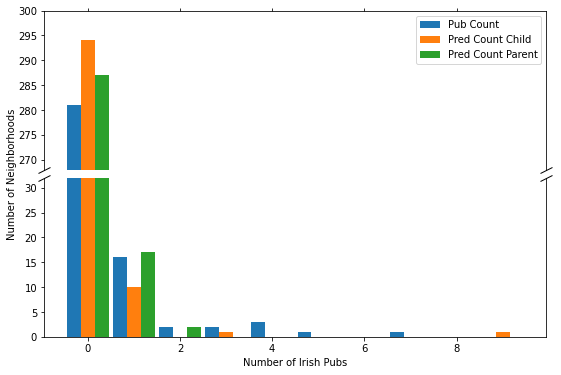

In [58]:
#We will create a broken axis plot of the histogram, following the example in the Matplotlib doc

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(9,6))
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

#plot histogram on oth axis
for ax in axs:
    ax.hist(neighborhoods_results[['Pub Count', 'Pred Count Child', 'Pred Count Parent']],
            bins=[i-0.5 for i in range(11)], 
            histtype='bar',
            align='mid',
            label=['Pub Count', 'Pred Count Child', 'Pred Count Parent'],
            rwidth=0.9,
           )

#zoom in and set legend
axs[0].set_ylim(268, 300)
axs[0].legend()
axs[1].set_ylim(0, 32)

# hide the spines between the axes
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].xaxis.tick_top()
axs[0].tick_params(labeltop=False)  # don't put tick labels at the top

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)

#Add axes label
labels = fig.add_subplot(111, frameon=False)
labels.set_xlabel('Number of Irish Pubs')
labels.set_ylabel('Number of Neighborhoods')
labels.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

We can see that while both models overestimate the number of neighborhoods with no pubs, the `Parent` model reproduces the distribution at a lower number of pubs more faithfully. However, it does not capture the existence of outlier with a very high number of pubs in one neighborhood. The `Child` model on the other hand predicts outliers, but it overestimates the number of pubs in them, which is what leads it to recommend these neighborhoods. There seems to be an overfitting where a very specific type of venue is considered highly likely to be associated with Irish Pubs in the `Child` data, which is smoothed out in the aggregated `Parent` data. For our purposes, the `Parent` model therefore seems more reliable, which can also be seen by its slightly higher performance during benchmarking.

Below, we show a map of the most recommended spots to open a new Irish Pub, according to the `Parent` model.

In [59]:
#Create the map
map_recom = folium.Map(location=[latitude, longitude], zoom_start=12)

#Get the colormap
from matplotlib.colors import rgb2hex
cm = plt.get_cmap('plasma')
low = 0.5
high = 1.8

#Helper function that we can apply to our dataframe to draw markers for each pub
def add_marker(row, target_map):
    label = '{} needs {:.2f} extra pubs.'.format(row['Neighborhood'], row['Excess Count Parent'])
    label = folium.Popup(label, parse_html=True)
    latitude = row['Latitude']
    longitude = row['Longitude']
    folium.CircleMarker(
        [latitude, longitude],
        popup=label,
        radius=8,
        fill=True,
        fill_opacity=0.7,
        color=rgb2hex(cm((row['Excess Count Parent']-low)/(high-low))),
    ).add_to(target_map)
    
neighborhoods_results.nlargest(10, 'Excess Count Parent').apply(add_marker, axis=1, args=(map_recom,))

map_recom

# 5. Conclusion
In this study, we modeled the distribution of Irish pubs in New York City using data on the types of venues present in each neighborhood. We were able to increase our models accuracy by grouping similar categories of venues together. These models could help an aspiring Irish pub owner by making a recommendation on where to open their business. Based on the other venues present there, we believe that Tribeca, in Manhattan, which does not currently have an Irish pub, should have at least one.

These results could certainly be refined by trying any of the other models presented above. We could also try to acquire more demographic data from public sources, such as median household income or land prices to get a more accurate description of each neighborhood.
